In [1]:
# 1. Import library
import tweepy
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Imports OK")

Imports OK


In [2]:
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAG3o5QEAAAAAEKSWTRAgw504o9VhzOmsrDFRhbs%3DEZOCLGZuutwRzYpopXpi1ka6WyM62LdhLVXEn9hRUATc5Zk6sA"

client = tweepy.Client(bearer_token=BEARER_TOKEN)
print("Client OK")

Client OK


In [3]:
query = '(#Whoosh OR #KCIC OR #KeretaCepat OR "Whoosh" OR "KCIC" OR "kereta cepat") lang:id -is:retweet'

response = client.search_recent_tweets(
    query=query,
    max_results=100,
    tweet_fields=["created_at", "author_id"]
)

tweets = response.data if response.data else []
print("Jumlah tweet:", len(tweets))

Jumlah tweet: 100


In [4]:
rows = []
for t in tweets:
    rows.append({
        "date": t.created_at,
        "author_id": t.author_id,
        "text": t.text
    })

df = pd.DataFrame(rows)
df

,date,author_id,text
0,2025-11-17 14:51:13+00:00,1278691354466381825,"@randomable_ Gpp jalanan kek gitu, yg penting ..."
1,2025-11-17 14:44:23+00:00,1655848158457638912,@arumanjani_ Mng ap yg d tinggalkan Jokowi? To...
2,2025-11-17 14:38:06+00:00,40486186,Libur nataru nanti belanja domestik di gerakan...
3,2025-11-17 14:36:03+00:00,453931027,https://t.co/5uMGQJh4IW\n\nApakah pak PYS peng...
4,2025-11-17 14:31:35+00:00,1428004543988523012,Omon2. Hutang whoosh saja masih dicicil. Mau h...
...,...,...,...
95,2025-11-17 08:34:55+00:00,1165864549,Sebelum mamah bapa gak ada cuma pengen ngajak ...
96,2025-11-17 08:27:03+00:00,214299051,JAKARTA - BANDUNG MENIKMATI KERETA WHOOSH\n\nS...
97,2025-11-17 08:26:43+00:00,1119586774710284294,padahal lebih enak beli dadakan pas nyampe kci...
98,2025-11-17 08:26:11+00:00,1119586774710284294,eh?! kenapa sekarang whoosh gabisa beli pake m...


In [14]:
import os
from transformers import logging

# Disable widget, disable progress bar
logging.set_verbosity_error()
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["DISABLE_TELEMETRY"] = "YES"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

label_map = {0: "negative", 1: "neutral", 2: "positive"}

In [16]:
def detect_sentiment(text):
    enc = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**enc).logits

    prob = F.softmax(logits, dim=1)[0].cpu().numpy()
    idx = prob.argmax()
    return label_map[idx], float(prob[idx])

In [17]:
sentiments = []
confidences = []

for text in df["text"]:
    s, c = detect_sentiment(text)
    sentiments.append(s)
    confidences.append(c)

df["sentiment"] = sentiments
df["confidence"] = confidences
df

,date,author_id,text,sentiment,confidence
0,2025-11-17 14:51:13+00:00,1278691354466381825,"@randomable_ Gpp jalanan kek gitu, yg penting ...",positive,0.548984
1,2025-11-17 14:44:23+00:00,1655848158457638912,@arumanjani_ Mng ap yg d tinggalkan Jokowi? To...,negative,0.873866
2,2025-11-17 14:38:06+00:00,40486186,Libur nataru nanti belanja domestik di gerakan...,negative,0.605676
3,2025-11-17 14:36:03+00:00,453931027,https://t.co/5uMGQJh4IW\n\nApakah pak PYS peng...,neutral,0.577554
4,2025-11-17 14:31:35+00:00,1428004543988523012,Omon2. Hutang whoosh saja masih dicicil. Mau h...,negative,0.673398
...,...,...,...,...,...
95,2025-11-17 08:34:55+00:00,1165864549,Sebelum mamah bapa gak ada cuma pengen ngajak ...,positive,0.494709
96,2025-11-17 08:27:03+00:00,214299051,JAKARTA - BANDUNG MENIKMATI KERETA WHOOSH\n\nS...,neutral,0.896785
97,2025-11-17 08:26:43+00:00,1119586774710284294,padahal lebih enak beli dadakan pas nyampe kci...,negative,0.736275
98,2025-11-17 08:26:11+00:00,1119586774710284294,eh?! kenapa sekarang whoosh gabisa beli pake m...,negative,0.788996


In [18]:
print("Jumlah:", df["sentiment"].value_counts())
print("\nProporsi (%):")
print(df["sentiment"].value_counts(normalize=True) * 100)

Jumlah: sentiment
neutral     51
negative    38
positive    11
Name: count, dtype: int64

Proporsi (%):
sentiment
neutral     51.0
negative    38.0
positive    11.0
Name: proportion, dtype: float64


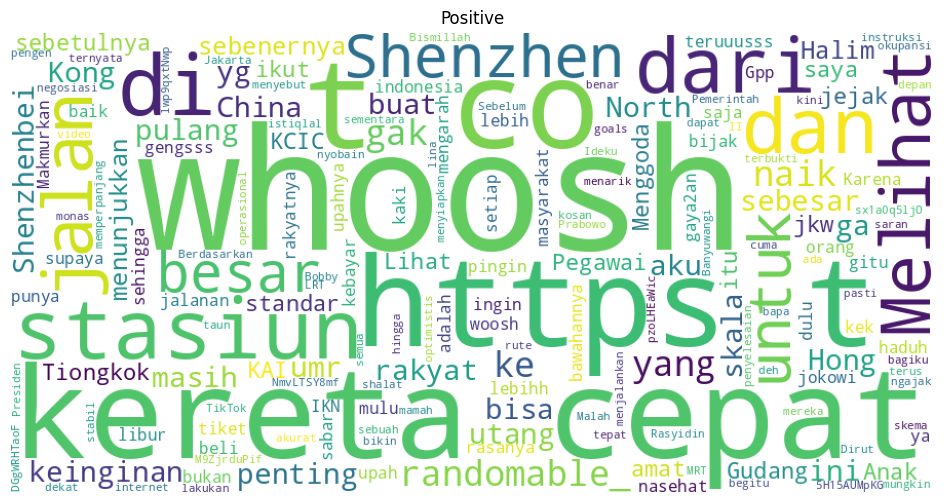

In [19]:
def show_wordcloud(title, texts):
    if not texts:
        print(f"Tidak ada tweet {title}")
        return
    wc = WordCloud(width=900, height=450, background_color="white")
    img = wc.generate(" ".join(texts))
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

show_wordcloud("Positive", df[df["sentiment"]=="positive"]["text"].tolist())

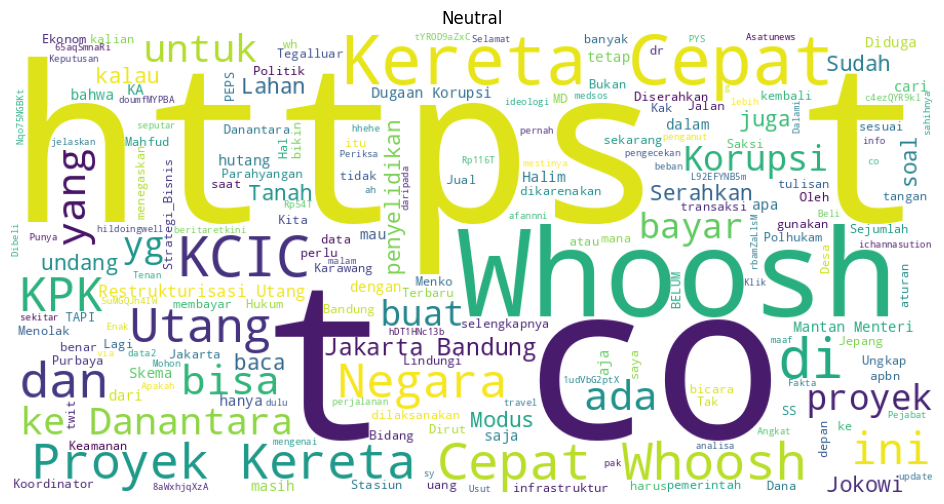

In [20]:
show_wordcloud("Neutral", df[df["sentiment"]=="neutral"]["text"].tolist())

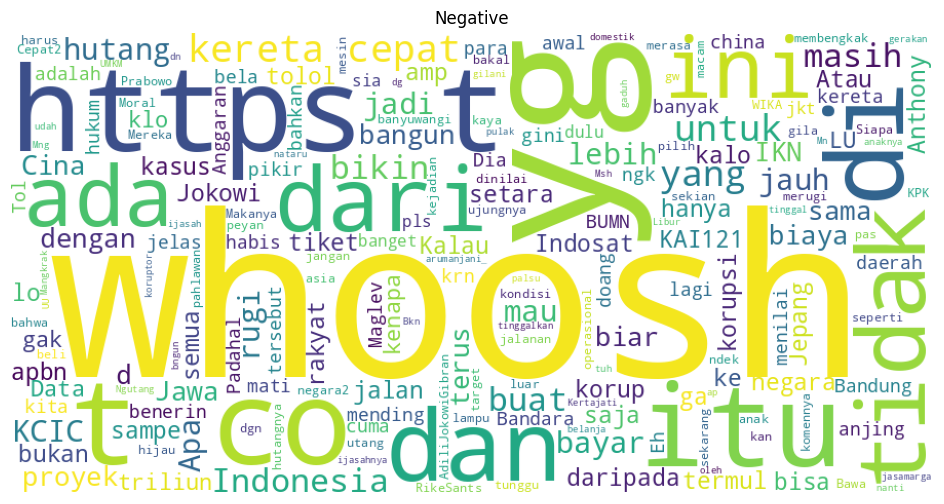

In [21]:
show_wordcloud("Negative", df[df["sentiment"]=="negative"]["text"].tolist())

In [22]:
df.to_csv("tweets_sentiment.txt", sep="\t", index=False, encoding="utf-8")
print("File saved: tweets_sentiment.txt")

File saved: tweets_sentiment.txt
